# Adsorption example code

In [1]:
!pip install aguaclara

     |████████████████████████████████| 92kB 2.5MB/s 
     |████████████████████████████████| 163kB 8.2MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.0-cp36-none-any.whl size=99623 sha256=825f997b13d73aa1c400470726af3cc31645cb384b92c729026f733978b1318a
  Stored in directory: /root/.cache/pip/wheels/34/e9/34/0d3722243083a982623290c205c14a08b54ed290ee29219fd2
  Created wheel for pint: filename=Pint-0.8.1-py2.py3-none-any.whl size=134156 sha256=1c148695cab2c9608e3b35085f9f96a91cd7b4dd3ffccb4c7f089e7f9d2ee1cb
  Stored in directory: /root/.cache/pip/wheels/b4/56/36/7c4d6a4e3660e233b95e3b0482551915cb184abca0f93ee1dd
Successfully built aguaclara pint


In [0]:
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
from pathlib import Path
import pandas as pd

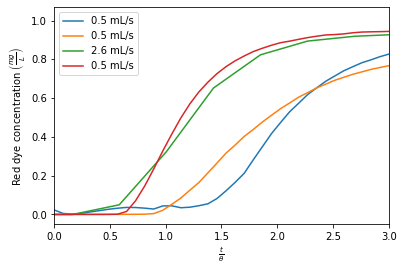

In [41]:
def adsorption_data(C_column, dirpath):
    """This function extracts the data from folder containing tab delimited
    files of adsorption data. The file must be the original tab delimited file.

    Parameters
    ----------
    C_column : int
        index of the column that contains the dissolved oxygen concentration
        data.
    dirpath : string
        path to the directory containing aeration data you want to analyze
    Returns
    -------
    filepaths : string list
        all file paths in the directory sorted by flow rate
    time_data : numpy array list
        sorted list of numpy arrays containing the times with units of seconds
    Examples
    --------
    """
    #return the list of files in the directory
    metadata = pd.read_csv(dirpath + '/metadata.txt', delimiter='\t')
    filenames = metadata['file name']
    #extract the flowrates from the filenames and apply units
    #sort airflows and filenames so that they are in ascending order of flow rates


    filepaths = [dirpath + '/' + i for i in filenames]
    #C_data is a list of numpy arrays. Thus each of the numpy data arrays can have different lengths to accommodate short and long experiments
    # cycle through all of the files and extract the column of data with oxygen concentrations and the times
    C_data=[ac.column_of_data(i,ac.notes(i).last_valid_index() + 1,C_column,-1,'mg/L') for i in filepaths]
    time_data=[(ac.column_of_time(i,ac.notes(i).last_valid_index() + 1,-1)).to(u.s) for i in filepaths]

    adsorption_collection = collections.namedtuple('adsorption_results','metadata filenames C_data time_data')
    adsorption_results = adsorption_collection(metadata, filenames, C_data, time_data)
    return adsorption_results


C_column = 1
dirpath = "https://raw.githubusercontent.com/monroews/CEE3530/master/Examples/data/Adsorption"



metadata, filenames, C_data, time_data = adsorption_data(C_column,dirpath)
metadata
Column_D = 1 * u.inch
Column_A = ac.area_circle(Column_D)
Column_L = 15.2 * u.cm
Column_V = Column_A * Column_L
#I'm guessing at the volume of water in the tubing, in the photometer, and in the space above and below the column. This parameter could be adjusted!
Tubing_V = 60 * u.mL
Flow_rate = ([metadata['flow (mL/s)'][i] for i in metadata.index])* u.mL/u.s
Mass_carbon= ([metadata['carbon (g)'][i] for i in metadata.index])* u.g
Tubing_HRT = Tubing_V/Flow_rate
#to make things simple we are assuming that the porosity is the same for sand and for activated carbon. That is likely not true!
porosity = 0.4
C_0 = 50 * u.mg/u.L

#estimate the HRT for all of the columns
HRT = (porosity * Column_V/Flow_rate).to(u.s)

#zero the concentration data by subtracting the value of the first data point from all data points. Do this in each data set.
for i in range(np.size(filenames)):
  C_data[i]=C_data[i]-C_data[i][0]

#Create a graph of the columns that didn't have any activated carbon
mylegend = []
for i in range(np.size(filenames)):
  if (metadata['carbon (g)'][i] == 0):
    plt.plot(time_data[i]/HRT[i] - Tubing_HRT[i]/HRT[i], C_data[i]/C_0,'-');
    mylegend.append(str(metadata['flow (mL/s)'][i]) + ' mL/s')

plt.xlabel(r'$\frac{t}{\theta}$');
plt.xlim(right=3,left=0);
plt.ylabel(r'Red dye concentration $\left ( \frac{mg}{L} \right )$');
plt.legend(mylegend);
plt.show()


/usr/local/lib/python3.6/dist-packages/pint/quantity.py:839: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__(other_magnitude / self._magnitude, 1 / self._units)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:802: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:802: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:839: RuntimeWarning: divide by zero encountered in true_divide
  return self.__class__(other_magnitude / self._magnitude, 1 / self._units)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:802: RuntimeWarning: divide by zero encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/usr/local/lib/python3.6/dist-packages/pint/quantity.py:802

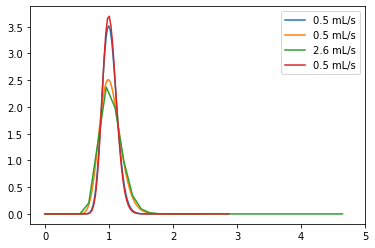

[240.74930375 220.89847948  36.5771956  184.49557235   0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]
[61.61562946 61.61562946 11.84915951 61.61562946 61.61562946 61.61562946
 61.61562946 66.11119041 66.11119041 11.84915951 61.61562946 11.84915951
 65.96962469]


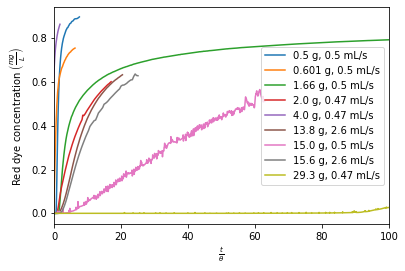

In [71]:

# Create an E curve from the F curves
DeltaC_data = np.empty_like(C_data)

# Below I'm playing with the data. Wondering if there is something we could learn from the E curves.
mylegend =[]
modeltheta = np.empty(13) * u.s
for i in range(np.size(filenames)):
  if (metadata['carbon (g)'][i] == 0):
    DeltaC_data[i]= np.gradient(C_data[i])  * u.mg/u.L
    AD_model = ac.Solver_AD_Pe(time_data[i], DeltaC_data[i], HRT[i], C_0)
    AD_E = ac.E_Advective_Dispersion((time_data[i]/AD_model.theta).to_base_units(), AD_model.Pe)
    AD_E[0] = 0
    modeltheta[i] = AD_model.theta
    plt.plot(time_data[i]/AD_model.theta, AD_E,'-');
    mylegend.append(str(metadata['flow (mL/s)'][i]) + ' mL/s')

plt.legend(mylegend);
plt.xlim(right=5)
plt.show()

#We can use the E model fit to obtain a good estimate of the HRT!
print(modeltheta.magnitude)
print(HRT.magnitude)

# create a graph of the columns that had different masses of activated carbon. Note that this includes systems with different flow rates!
mylegend =[]
for i in range(np.size(filenames)):
  if (metadata['carbon (g)'][i] != 0):
    plt.plot(time_data[i]/HRT[i] - Tubing_HRT[i]/HRT[i], C_data[i]/C_0,'-');
    mylegend.append(str(ac.round_sig_figs(metadata['carbon (g)'][i],3)) + ' g, ' + str(ac.round_sig_figs(metadata['flow (mL/s)'][i],2)) + ' mL/s')

plt.xlabel(r'$\frac{t}{\theta}$');
plt.xlim(right=100,left=0);
plt.ylabel(r'Red dye concentration $\left ( \frac{mg}{L} \right )$');
plt.legend(mylegend);
plt.show()